<a href="https://colab.research.google.com/github/Hing-9/popup_store/blob/main/KcElectra_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 95.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 88.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 24.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Graduation-Thesis/NER

Mounted at /content/drive
/content/drive/MyDrive/Graduation-Thesis/NER


In [ ]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

import torch
import torch.backends.cudnn as cudnn
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

In [ ]:
torch.manual_seed(98)
torch.cuda.manual_seed(98)
torch.cuda.manual_seed_all(98)
cudnn.benchmark = False
cudnn.deterministic = True

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.cuda.get_device_name(0)

'Tesla T4'

In [ ]:
def file_to_data(path) :
    with open(path, 'r', encoding='UTF-8') as f :
        return json.load(f)['data']

def data_only_org(data) :
    ner_sentences = []
    for sentence in data :
        if sentence['ner'] : # NER 있는 데이터 발견
            tags = sentence['ner']['tags']
            org_flag = False
            for tag in tags :
                if tag['tag'] == 'ORG' :
                    org_flag = True
                    break
            if org_flag :
                ner_sentences.append(sentence)
    return ner_sentences

In [ ]:
data_영한 = file_to_data('./일상생활및구어체_영한_train_set.json')
data_한영 = file_to_data('./일상생활및구어체_한영_train_set.json')

In [ ]:
# 데이터 결합
data = data_영한.copy()
data.extend(data_한영.copy())

print(f'{len(data)} = {len(data_영한)} + {len(data_한영)}')

assert len(data) == len(data_영한)+len(data_한영)

2400307 = 1200307 + 1200000


In [ ]:
print(f'전체 데이터 개수 : '+str(len(data)))
data = data_only_org(data)
print(f'NER에 ORG가 포함된 데이터 개수 : '+str(len(data)))

전체 데이터 개수 : 2400307
NER에 ORG가 포함된 데이터 개수 : 30244


In [ ]:
data[0]

{'sn': 'ECOAR2T00367',
 'data_set': '일상생활및구어체',
 'domain': '해외고객과의채팅',
 'subdomain': '숙박,음식점',
 'en_original': 'I am a professor at BBB1.',
 'en': 'I am a professor at BBB1.',
 'mt': '저는 BBB1의 교수입니다.',
 'ko': '저는 BBB1의 교수입니다.',
 'source_language': 'en',
 'target_language': 'ko',
 'word_count_ko': 3.0,
 'word_count_en': 6.0,
 'word_ratio': 0.5,
 'file_name': '해외고객과의채팅_숙박,음식점.xlsx',
 'source': '크라우드 소싱',
 'license': 'open',
 'style': '구어체',
 'included_unknown_words': False,
 'ner': {'text': '저는 <ORG>BBB1의</ORG> 교수입니다.',
  'tags': [{'tag': 'ORG', 'value': 'BBB1의', 'position': '[3, 8]'}]}}

In [ ]:
# # 이거는 실행해볼 필요는 없음!!
# def kind_of_ner_tags(data) :
#     result = []
#     for sentence in data :
#         tags = sentence['ner']['tags']
#         for tag in tags :
#             result.append(tag['tag'])
    
#     result = list(set(result))
#     return result

# def value_for_tag(find_tag, data) :
#     result = []
#     MAX_CNT = 10
#     cnt = 0

#     for sentence in data :
#         tags = sentence['ner']['tags']
#         for tag in tags :
#             if tag['tag'] == find_tag :
#                 result.append(tag['value'])
#                 cnt += 1
        
#         if cnt >= MAX_CNT :
#                 break;
    
#     return result


# tags = kind_of_ner_tags(data)
# print(f'모든 데이터에서 검출된 NER TAGS : {tags}')
# print()

# for tag in tags :
#     print(f'==== TAG : {tag}====')
#     print(value_for_tag(tag, data))

In [ ]:
# # 혹시나.. 팝업이 들어간 데이터를 추출해보자
# def find_popup(data) : 
#     result = []
#     for sentence in data :
#         if '팝업' in sentence['ko'] :
#             result.append(sentence['ko'])
#         # elif '스토어' in sentence['ko'] :
#         #     result.append(sentence['ko'])
#     return result

# find_popup(data)

In [ ]:
# ORG 태그에 브랜드명을 넣어 학습시키는게 정당해보임.
# 브랜드명은 소상공인 데이터
brand_data = pd.read_csv('./소상공인시장진흥공단_상가(상권)정보_서울_202212.csv', encoding='UTF-8')
brand_names = brand_data['상호명'].values

In [ ]:
# 랜덤하게 브랜드명을 입력
rnd_idx = random.randrange(0, len(brand_names))
brand_names[rnd_idx]

'까사브라질그릴'

In [ ]:
def random_brand_transfer(data) :
    tmp_data = data.copy()

    tokens_arr = []
    tags_arr  = []

    for idx, sentence in enumerate(tmp_data) :

        # 위에서 데이터를 한번 걸렀다.
        # NER 태그가 있고, ORG 태그가 있는 것들로!
        
        tags = sentence['ner']['tags']
        position_arr = []

        # 태그 위치를 파악한다.
        for tag in tags :

            if tag['tag'] == 'ORG' :
                positions = tag['position'][1:-1].split(',')
                start_index = int(positions[0])
                end_index = int(positions[1])

                index_arr = []
                index_arr.append(start_index)
                index_arr.append(end_index)
                position_arr.append(index_arr)
        
        # 내림차순으로 정렬
        position_arr.sort(reverse=True)
        new_sentence = sentence['ko']
        for idx_small, position in enumerate(position_arr) :
            
            # 브랜드 이름 랜덤 추출 및 세팅
            rnd_idx = random.randrange(0, len(brand_names))
            chg_org = brand_names[rnd_idx]

            new_sentence = new_sentence[:position[0]] + chg_org + new_sentence[position[1]:]

            # 인덱스 증가분
            indeCrease = len(chg_org) - (position[1]-position[0])

            # 인덱스 재설정
            position[1] += indeCrease
            for pre_position in position_arr[:idx_small] :
                pre_position[0] += indeCrease
                pre_position[1] += indeCrease

        # if idx == 26805 :
        #     print(sentence['ko'])
        #     print(new_sentence)
            
        #     for word_pos in position_arr :
        #         print(new_sentence[word_pos[0]:word_pos[1]])

        # token과 tag 세팅 시작
        new_sentence = new_sentence.replace(' ', '_')
        tokens_sentence = list(new_sentence)
        tags_sentence = []
        for i in range(len(tokens_sentence)) :
            tags_sentence.append('O')
        
        for position in position_arr :
            for i in range(position[0], position[1]) :
               
                if i == position[0] :
                   tag_nm = 'B-ORG'
                else :
                    tag_nm = 'I-ORG'
               
                tags_sentence[i] = tag_nm

        # if idx == 26805 :
        #     print(tokens_sentence)
        #     print(tags_sentence)

        tokens_arr.append(tokens_sentence)
        tags_arr.append(tags_sentence)

    return tokens_arr, tags_arr

texts, tags = random_brand_transfer(data)

len(texts)
len(tags)

30244

In [ ]:
unique_tags = set(tag for doc in tags for tag in doc)
tag2id = {tag: id for id, tag in enumerate(unique_tags)}
id2tag = {id: tag for tag, id in tag2id.items()}

for i, tag in enumerate(unique_tags):
    print(tag)  # 학습을 위한 label list를 확인

B-ORG
O
I-ORG


## EDA

Text(0, 0.5, 'Probability')

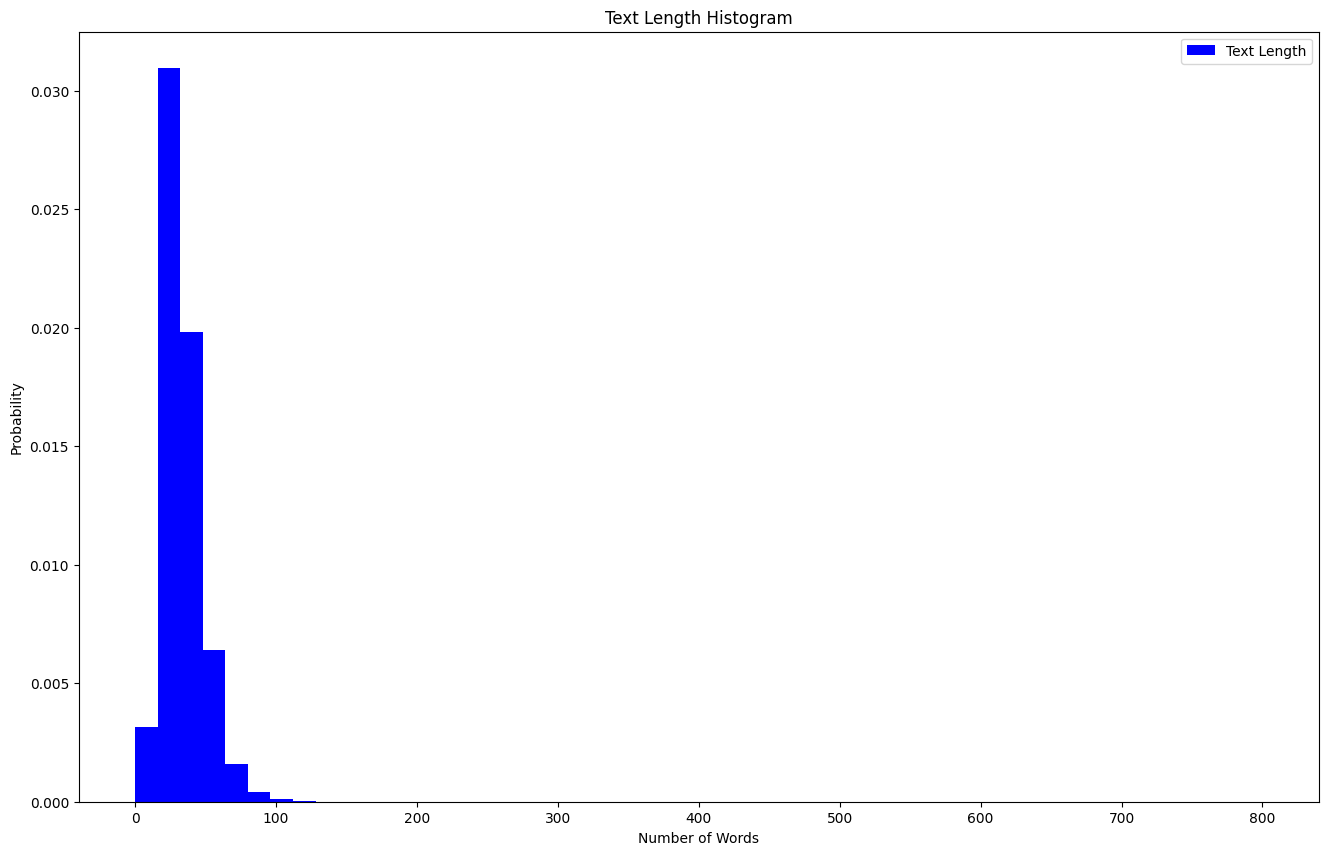

In [ ]:
texts_len = [len(x) for x in texts]

plt.figure(figsize=(16,10))
plt.hist(texts_len, bins=50, range=[0,800], facecolor='b', density=True, label='Text Length')
plt.title('Text Length Histogram')
plt.legend()
plt.xlabel('Number of Words')
plt.ylabel('Probability')

In [ ]:
for tag in list(tag2id.keys()) : 
    globals()[tag] = 0

for tag in tags : 
    for ner in tag : 
        globals()[ner] += 1

for tag in list(tag2id.keys()) : 
    print('{:>6} : {:>7,}'. format(tag, globals()[tag]))

 B-ORG :  32,421
     O : 808,038
 I-ORG : 151,041


## Split

In [ ]:
from sklearn.model_selection import train_test_split

train_texts, test_texts, train_tags, test_tags = train_test_split(texts, tags, test_size=.2, random_state=98)

In [ ]:
print('Train 문장 : {:>6,}' .format(len(train_texts)))
print('Train 태그 : {:>6,}' .format(len(train_tags)))
print('Test  문장 : {:>6,}' .format(len(test_texts)))
print('Test  태그 : {:>6,}' .format(len(test_tags)))

Train 문장 : 24,195
Train 태그 : 24,195
Test  문장 :  6,049
Test  태그 :  6,049


## Tokenizing

In [ ]:
model_name = "beomi/KcELECTRA-base-v2022"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
pad_token_id = tokenizer.pad_token_id # 0
cls_token_id = tokenizer.cls_token_id # 101
sep_token_id = tokenizer.sep_token_id # 102
pad_token_label_id = tag2id['O']    # tag2id['O']
cls_token_label_id = tag2id['O']
sep_token_label_id = tag2id['O']

In [ ]:
# 기존 토크나이저는 wordPiece tokenizer로 tokenizing 결과를 반환합니다.
# 데이터 단위를 음절 단위로 변경했기 때문에, tokenizer도 음절 tokenizer로 바꿔줘야함

# berttokenizer를 쓸건데 여기에 들어있는 8000개 밖에 안되는 한국어가 들어있지만 많은수가 음절이다.
# 한국어들의 거의 음절로 존재. -> 음절 단위 tokenizer를 적용해도 vocab id를 어느 정도 획득할 수 있음.
# 그래서 음절로 쪼개면 UNK가 별로 없을 것이다.

def ner_tokenizer(sent, max_seq_length):    
    pre_syllable = "_"
    input_ids = [pad_token_id] * (max_seq_length - 1)
    attention_mask = [0] * (max_seq_length - 1)
    token_type_ids = [0] * max_seq_length
    sent = sent[:max_seq_length-2]

    for i, syllable in enumerate(sent):
        if syllable == '_':
            pre_syllable = syllable
        if pre_syllable != "_":
            syllable = '##' + syllable  # 중간 음절에는 모두 prefix를 붙입니다.
            # 우리가 구성한 학습 데이터도 이렇게 구성되었기 때문이라고 함.
            # 이순신은 조선 -> [이, ##순, ##신, ##은, 조, ##선]
        pre_syllable = syllable

        input_ids[i] = (tokenizer.convert_tokens_to_ids(syllable))
        attention_mask[i] = 1
    
    input_ids = [cls_token_id] + input_ids
    input_ids[len(sent)+1] = sep_token_id
    attention_mask = [1] + attention_mask
    attention_mask[len(sent)+1] = 1
    return {"input_ids":input_ids,
            "attention_mask":attention_mask,
            "token_type_ids":token_type_ids}

In [ ]:
print(train_texts[0])
print('='*40)
print(ner_tokenizer(train_texts[0], 5))
# 'token_type_ids': [0, 0, 0, 0, 0] 은 segmentA로 0000으로 되어있는거.

['아', '버', '지', '가', '_', '삼', '풍', '인', '테', '리', '어', '_', '야', '구', '_', '경', '기', '_', 'V', 'I', 'P', '_', '티', '켓', '을', '_', '샀', '어', '?']
{'input_ids': [2, 2469, 4133, 4044, 3], 'attention_mask': [1, 1, 1, 1, 1], 'token_type_ids': [0, 0, 0, 0, 0]}


In [ ]:
tokenized_train_sentences = []
tokenized_test_sentences = []

for text in train_texts:    # 전체 데이터를 tokenizing 합니다.
    tokenized_train_sentences.append(ner_tokenizer(text, 128))
for text in test_texts:
    tokenized_test_sentences.append(ner_tokenizer(text, 128))

In [ ]:
# 우리의 label도 truncation과 tokenizing이 필요하다.
def encode_tags(tags, max_seq_length):
    # label 역시 입력 token과 개수를 맞춰줍니다
    tags = tags[:max_seq_length-2]
    labels = [tag2id[tag] for tag in tags]
    labels = [tag2id['O']] + labels

    padding_length = max_seq_length - len(labels)
    labels = labels + ([pad_token_label_id] * padding_length)

    return labels

In [ ]:
encode_tags(train_tags[0], 5)

[1, 1, 1, 1, 1]

In [ ]:
train_labels = []
test_labels = []

for tag in train_tags:
    train_labels.append(encode_tags(tag, 128))

for tag in test_tags:
    test_labels.append(encode_tags(tag, 128))

In [ ]:
len(train_labels), len(test_labels)

(24195, 6049)

In [ ]:
class TokenDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val) for key, val in self.encodings[idx].items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TokenDataset(tokenized_train_sentences, train_labels)
test_dataset = TokenDataset(tokenized_test_sentences, test_labels)

In [ ]:
from transformers import BertForTokenClassification, Trainer, TrainingArguments, AutoModelForTokenClassification,EarlyStoppingCallback
import sys
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=5,              # total number of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    logging_dir='./logs',            # directory for storing logs
    logging_steps=1000, # 1000번쨰 steps마다 log를 보여줌 
    learning_rate=3e-5,
    weight_decay=0.01,
    save_total_limit=5,
    save_strategy='steps', # steps로 해야 earlystop이 가능
    evaluation_strategy='steps',
    save_steps=1000, # 1000번쨰 step마다 저장
    eval_steps=1000, # 1000번째 step마다 평가
    seed=15,
    load_best_model_at_end=True # 가장 좋은 성능의 모델로...
)

In [ ]:
model = AutoModelForTokenClassification.from_pretrained(model_name, num_labels=len(unique_tags))
model.to(device)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=test_dataset,# evaluation dataset
    callbacks = [EarlyStoppingCallback(early_stopping_patience=2)] #loss가 2번 감소하지 않으면 스탑
)

Some weights of the model checkpoint at beomi/KcELECTRA-base-v2022 were not used when initializing ElectraForTokenClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForTokenClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.bias', 'classifier.weight']

In [ ]:
import gc
gc.collect()

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
1000,0.019200,0.007888
2000,0.008100,0.007551
3000,0.006200,0.005435
4000,0.003500,0.005361
5000,0.003400,0.005139
6000,0.003300,0.004557
7000,0.001700,0.005667
8000,0.002100,0.005500


TrainOutput(global_step=8000, training_loss=0.00594474145770073, metrics={'train_runtime': 2120.6217, 'train_samples_per_second': 57.047, 'train_steps_per_second': 7.132, 'total_flos': 4180132657866240.0, 'train_loss': 0.00594474145770073, 'epoch': 2.64})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.004557328298687935,
 'eval_runtime': 43.5554,
 'eval_samples_per_second': 138.881,
 'eval_steps_per_second': 2.181,
 'epoch': 2.64}

In [ ]:
predictions = trainer.predict(test_dataset)
print(predictions.predictions.shape, predictions.label_ids.shape)

(6049, 128, 3) (6049, 128)


In [ ]:
preds = np.argmax(predictions.predictions, axis=-1)

In [ ]:
index_to_ner = {i:j for j, i in tag2id.items()}
f_label = [i for i, j in tag2id.items()]
val_tags_l = [index_to_ner[x] for x in np.ravel(predictions.label_ids).astype(int).tolist()]
y_predicted_l = [index_to_ner[x] for x in np.ravel(preds).astype(int).tolist()]

In [ ]:
#데이터셋 추가
print(classification_report(val_tags_l, y_predicted_l, labels=f_label))

              precision    recall  f1-score   support

       B-ORG       0.98      0.97      0.98      6518
           O       1.00      1.00      1.00    737289
       I-ORG       0.98      0.99      0.99     30465

    accuracy                           1.00    774272
   macro avg       0.99      0.99      0.99    774272
weighted avg       1.00      1.00      1.00    774272



In [ ]:
trainer.save_model('kcelectra_base_new')

## 학습 후 결과 확인

In [ ]:
model = AutoModelForTokenClassification.from_pretrained('kcelectra_base_new', num_labels=len(unique_tags))
model.to(device)

ElectraForTokenClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(54343, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Laye

In [ ]:
def ner_inference(text) : 
  
    model.eval()
    text = text.replace(' ', '_')

    predictions , true_labels = [], []
    
    tokenized_sent = ner_tokenizer(text, len(text)+2)
    input_ids = torch.tensor(tokenized_sent['input_ids']).unsqueeze(0).to(device)
    attention_mask = torch.tensor(tokenized_sent['attention_mask']).unsqueeze(0).to(device)
    token_type_ids = torch.tensor(tokenized_sent['token_type_ids']).unsqueeze(0).to(device)    
    
    with torch.no_grad():
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids)
        
    logits = outputs['logits']
    logits = logits.detach().cpu().numpy()
    label_ids = token_type_ids.cpu().numpy()

    predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
    true_labels.append(label_ids)

    pred_tags = [list(tag2id.keys())[p_i] for p in predictions for p_i in p]

    print('{}\t{}'.format("TOKEN", "TAG"))
    print("===========")
    # for token, tag in zip(tokenizer.decode(tokenized_sent['input_ids']), pred_tags):
    #   print("{:^5}\t{:^5}".format(token, tag))
    for i, tag in enumerate(pred_tags):
        print("{:^5}\t{:^5}".format(tokenizer.convert_ids_to_tokens(tokenized_sent['input_ids'][i]), tag))

In [ ]:
text = '팝가가 미리 알려주는 업커밍 팝업스토어 포켓몬 스프링 페스타 in 롯데월드몰 2023 04.28(금)-05.08(월) 송파구 올림픽로 300, 롯데월드몰 & 월드파크 매일: 10:30~22:00 포켓몬과 함께 모험을 떠날 어린&어른이들 다 모여라-** ** 봄맞이 포켓몬 팝업스토어 가 잠실 롯데월드몰 곳곳에서 진행될 예정이야! 포켓몬 캐릭터 봉제 인형, 스티커, 필기구 등 귀여운 굿즈와 대형 포토존을 포함한 다채로운 체험 거리를 한자리에서 만나볼 수 있대! 포켓몬 애니메이션 & 극장판 컨셉의 대규모 포토존 (롯데월드몰 야외광장) 국내 최초 포켓몬 카드 갤러리 (롯데월드몰 5층 아이코닉 브릿지) 포켓몬 스칼렛 & 바이올렛 배틀 체험 이벤트 (롯데월드몰 4층 키즈플로어) 포켓몬 팝업스토어는 현장 방문 예약제로 운영되니 참고해 이번 주, 금요일 포켓몬 팝업스토어로 달려가 보자구 왼쪽 하단을 눌러 팝업스토어 알림 신청하고 놓치지 말자!'

ner_inference(text)

TOKEN	TAG
[CLS]	  O  
  팝  	  O  
 ##가 	  O  
 ##가 	  O  
  _  	  O  
  미  	  O  
 ##리 	  O  
  _  	  O  
  알  	  O  
 ##려 	  O  
 ##주 	  O  
 ##는 	  O  
  _  	  O  
  업  	  O  
 ##커 	  O  
 ##밍 	  O  
  _  	  O  
  팝  	  O  
 ##업 	  O  
 ##스 	  O  
 ##토 	  O  
 ##어 	  O  
  _  	  O  
  포  	  O  
 ##켓 	  O  
 ##몬 	  O  
  _  	  O  
  스  	  O  
 ##프 	  O  
 ##링 	  O  
  _  	  O  
  페  	  O  
 ##스 	  O  
 ##타 	  O  
  _  	  O  
  i  	  O  
 ##n 	  O  
  _  	  O  
  롯  	  O  
 ##데 	  O  
 ##월 	  O  
 ##드 	  O  
 ##몰 	  O  
  _  	  O  
  2  	  O  
 ##0 	  O  
 ##2 	  O  
 ##3 	  O  
  _  	  O  
  0  	  O  
 ##4 	  O  
[UNK]	  O  
 ##2 	  O  
 ##8 	  O  
[UNK]	  O  
 ##금 	  O  
[UNK]	  O  
[UNK]	  O  
 ##0 	  O  
 ##5 	  O  
[UNK]	  O  
 ##0 	  O  
 ##8 	  O  
[UNK]	  O  
 ##월 	  O  
[UNK]	  O  
  _  	  O  
  송  	  O  
 ##파 	  O  
 ##구 	I-ORG
  _  	  O  
  올  	  O  
 ##림 	  O  
 ##픽 	  O  
 ##로 	  O  
  _  	  O  
  3  	  O  
 ##0 	  O  
 ##0 	  O  
[UNK]	  O  
  _  	  O  
  롯  	  O  
 ##데 	

# 대 실 패 !